# Benchmark with other methods

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP

In [2]:
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams.update({
    "pdf.fonttype": 42,         
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 0.8,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

In [5]:
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/simulation/final" # Processed data
SAVE_PATH = "/import/home2/share/yqzeng/MacSGP/results/simulation/final" # Deconvolution results
FIG_PATH = "/import/home2/share/yqzeng/MacSGP/experiments/simulation/figs" # Figures

In [6]:
adata_st = ad.read_h5ad(os.path.join(SAVE_PATH, "adata_result.h5ad"))
factor_true = adata_st.obsm['simulated_factor']
factor_macsgp = adata_st.obsm['factor']['celltype_0']

In [7]:
ct = ''  # Cell type of interest
methods = ['nmf', 'mofa', 'spicemix', 'stamp']
factors = []
loadings = []
for method in methods:
    factor_i = pd.read_csv(os.path.join(SAVE_PATH, method, 'factors.csv'), index_col=0)
    factors.append(factor_i)
    loading_i = pd.read_csv(os.path.join(SAVE_PATH, method, 'loadings.csv'), index_col=0)
    loadings.append(loading_i)

In [23]:
factor_ct = np.concatenate([factors[0].iloc[:, 0].values.reshape(-1, 1), factors[1].iloc[:, 0].values.reshape(-1, 1), 
                factors[2].iloc[:, 3].values.reshape(-1, 1), factors[3].iloc[:, 0].values.reshape(-1, 1)], axis=1)

loading_ct = np.concatenate([loadings[0].iloc[:, 0].values.reshape(1, -1), loadings[1].iloc[:, 0].values.reshape(1, -1), 
                -loadings[2].iloc[:, 3].values.reshape(1, -1), loadings[3].iloc[:, 0].values.reshape(1, -1)], axis=0)

factor_ct_df = pd.DataFrame(factor_ct, index=adata_st.obs_names, columns=methods)
loading_ct_df = pd.DataFrame(loading_ct, index=methods, columns=adata_st.var_names)

factor_ct_df['macsgp'] = adata_st[factor_ct_df.index, :].obsm['factor']['celltype_0']
factor_ct_df['true'] = pd.DataFrame(adata_st[factor_ct_df.index, :].obsm['simulated_factor']['celltype_0'].values, columns=['true'], index=factor_ct_df.index)
loading_ct_df.loc['macsgp', :] = adata_st[factor_ct_df.index, :].varm['loading']['celltype_0']

In [24]:
# normalized factor_ct_df to -1 to 1
factor_ct_df_norm = factor_ct_df.copy()
for col in factor_ct_df_norm.columns:
    min_val = factor_ct_df_norm[col].min()
    max_val = factor_ct_df_norm[col].max()
    factor_ct_df_norm[col] = 2 * (factor_ct_df_norm[col] - min_val) / (max_val - min_val) - 1

In [20]:
import seaborn as sns
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import matplotlib.pyplot as plt

new_cmap_1 = set_zero_in_cmap_to_transparent(cmap=sns.color_palette("Reds", as_cmap=True))
colors=new_cmap_1(np.arange(new_cmap_1.N))
colors = colors[new_cmap_1.N*1//20:new_cmap_1.N*4//4]
new_cmap_1 = ListedColormap(colors)
names = ['NMF', 'MOFA', 'SpiceMix', 'STAMP', 'MacSGP']

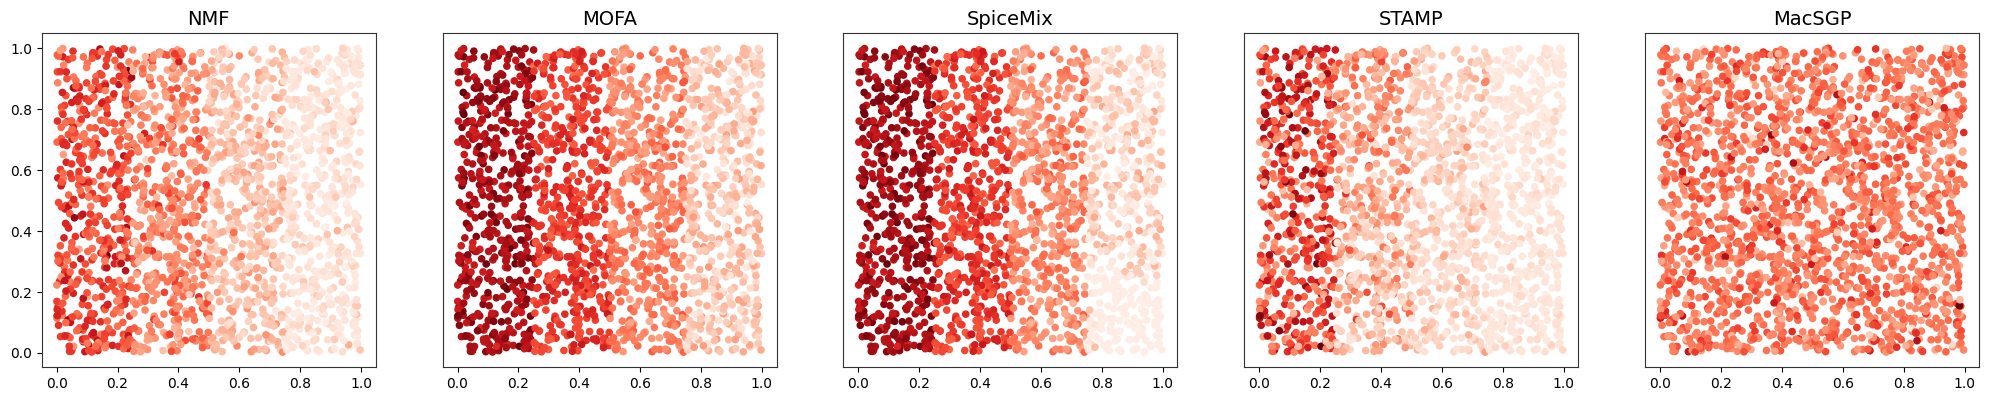

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axes.flat):
    ax.scatter(
        adata_st.obsm["spatial"][:, 0],
        adata_st.obsm["spatial"][:, 1],
        c=factor_ct_df.iloc[:, i],
        s=20,
        cmap=new_cmap_1,
    )
    ax.set_title(names[i])
    #ax.set_xticks([])
    
    if i != 0:
        ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
#plt.savefig(os.path.join(FIG_PATH, 'simulated_factors_scatter.pdf'))
plt.show()

In [33]:
import libpysal
import numpy as np
import esda
from libpysal.weights import KNN

cor = np.ones(5)
coords = adata_st[factor_ct_df.index, :].obsm['spatial']
w = KNN.from_array(coords, k=12)
w.transform = 'r'  # 行标准化

for i, method in enumerate(['nmf', 'mofa', 'spicemix', 'stamp', 'macsgp']):
    bi = esda.Moran_BV(factor_ct_df['true'], factor_ct_df[method], w, permutations=999)
    cor[i] = bi.I
    print(f'Method: {method}, I: {bi.I}, p-value: {bi.p_sim}')

Method: nmf, I: -0.18365085857757518, p-value: 0.001
Method: mofa, I: 0.05120396105970556, p-value: 0.018
Method: spicemix, I: -0.6286262480838376, p-value: 0.001
Method: stamp, I: 0.6410677482916484, p-value: 0.001
Method: macsgp, I: 0.8758176393586253, p-value: 0.001


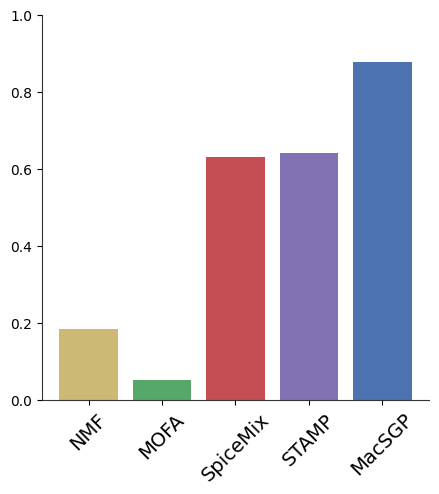

In [ ]:
# spatial coherence

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# 竖状图的 correlation coefficients
axes.bar(methods, np.abs(cor), color=['#CCB974', '#55A868', '#C44E52', '#8172B3', '#4C72B0'])
#reset labels
axes.set_xticklabels(['NMF', 'MOFA', 'SpiceMix', 'STAMP', 'MacSGP'], rotation=45, size=14)
axes.set_ylim(0, 1)
# axes.set_ylabel('Program coherence')
# 去掉上边框和右边框
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
#plt.savefig(os.path.join(SAVE_PATH, 'factor_correlation_bar.pdf'))
plt.show()

In [26]:
adata_st.varm['simulated_loading'] = pd.DataFrame(adata_st.varm['simulated_loading'], index=adata_st.var_names, columns=['1'])
loading_ct_df_abs = loading_ct_df.abs()
methods = loading_ct_df_abs.index.tolist()
truth = [f'gene_{i}' for i in range(200)]
cor = pd.concat([loading_ct_df, adata_st.varm['simulated_loading'].T.abs()]).T.corr()['1'].abs()

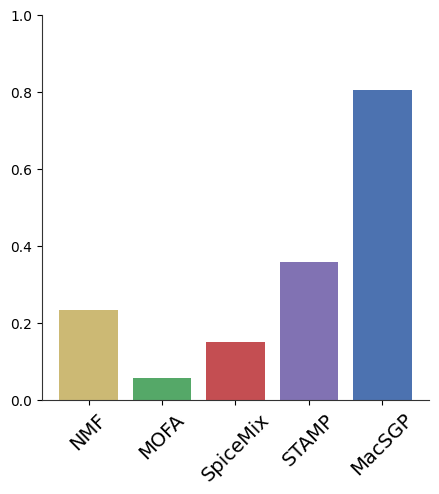

In [ ]:
# gene program cogerence

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# 竖状图的 correlation coefficients
axes.bar(cor.index[:-1], cor.values[:-1], color=['#CCB974', '#55A868', '#C44E52', '#8172B3', '#4C72B0'])
#reset labels
axes.set_xticklabels(['NMF', 'MOFA', 'SpiceMix', 'STAMP', 'MacSGP'], rotation=45, size=14)
axes.set_ylim(0, 1)
# axes.set_ylabel('Program coherence')
# 去掉上边框和右边框
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
#plt.savefig(os.path.join(SAVE_PATH, 'loading_correlation_bar.pdf'))
plt.show()

In [17]:
factor_ct = np.concatenate([factors[0].iloc[:, 1].values.reshape(-1, 1), -factors[1].iloc[:, 0].values.reshape(-1, 1), 
                            factors[2].iloc[:, 2].values.reshape(-1, 1), factors[3].iloc[:, 4].values.reshape(-1, 1)], axis=1)
loading_ct = np.concatenate([loadings[0].iloc[:, 1].values.reshape(1, -1), -loadings[1].iloc[:, 0].values.reshape(1, -1), 
                            loadings[2].iloc[:, 2].values.reshape(1, -1), loadings[3].iloc[:, 4].values.reshape(1, -1)], axis=0)

factor_ct_df = pd.DataFrame(factor_ct, index=adata_st.obs_names, columns=methods)
loading_ct_df = pd.DataFrame(loading_ct, index=methods, columns=adata_st.var_names)

factor_ct_df['macsgp'] = adata_st[factor_ct_df.index, :].obsm['factor']['celltype_1']
loading_ct_df.loc['macsgp', :] = adata_st[factor_ct_df.index, :].varm['loading']['celltype_1']

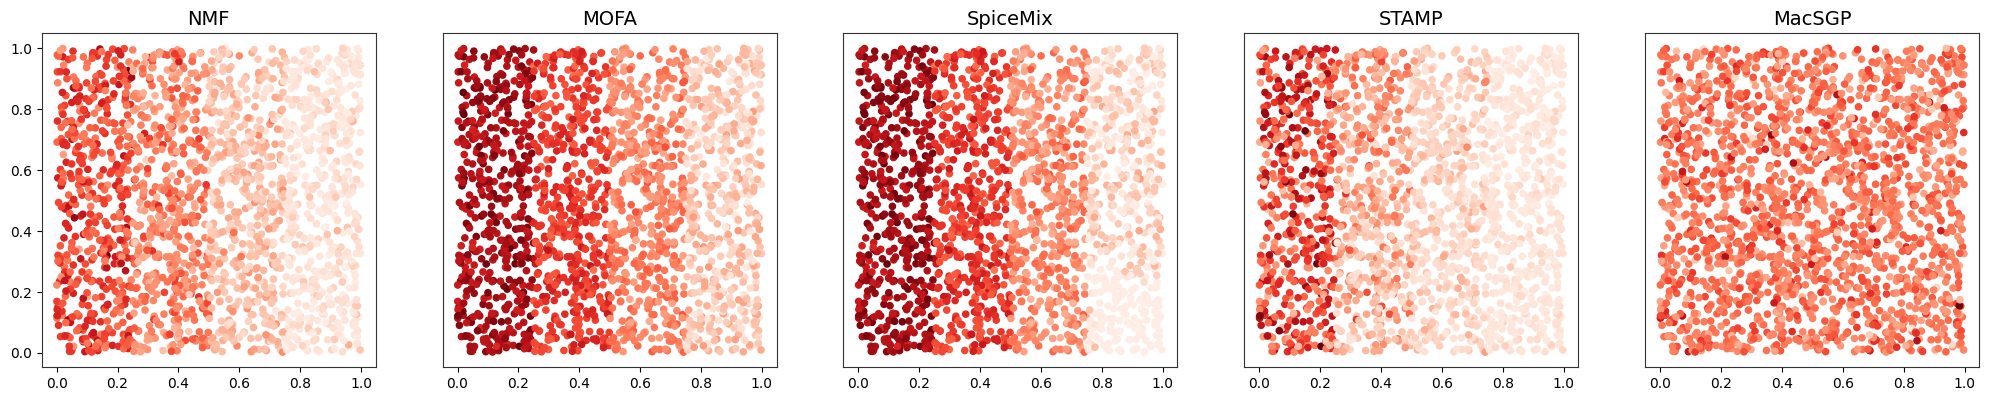

In [ ]:
# cell type 2

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axes.flat):
    ax.scatter(
        adata_st.obsm["spatial"][:, 0],
        adata_st.obsm["spatial"][:, 1],
        c=factor_ct_df.iloc[:, i],
        s=20,
        cmap=new_cmap_1,
    )
    ax.set_title(names[i])
    #ax.set_xticks([])
    if i != 0:
        ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

#plt.savefig(os.path.join(FIG_PATH, 'simulated_factors_scatter_2.pdf'))
plt.show()